In [8]:
#!pip install yfinance
import yfinance as yf
import keras
import tensorflow as tf

In [9]:
stock_symbol = 'BAJAJFINSV.NS'

In [10]:
data = yf.download(tickers=stock_symbol,period='5y',interval='1d')

[*********************100%***********************]  1 of 1 completed


In [11]:
type(data)

pandas.core.frame.DataFrame

In [12]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-05-21,573.500000,577.50000,562.080017,572.205017,571.187195,1630750
2018-05-22,571.500000,602.00000,568.215027,597.179993,596.117798,4291380
2018-05-23,594.900024,596.00000,577.000000,579.005005,577.975098,1623480
2018-05-24,582.000000,587.50000,570.369995,582.640015,581.603760,1544930
2018-05-25,586.400024,609.72998,585.000000,607.169983,606.090027,3166080


In [13]:
len(data)

1235

In [14]:
opn = data[['Open']]

<Axes: xlabel='Date'>

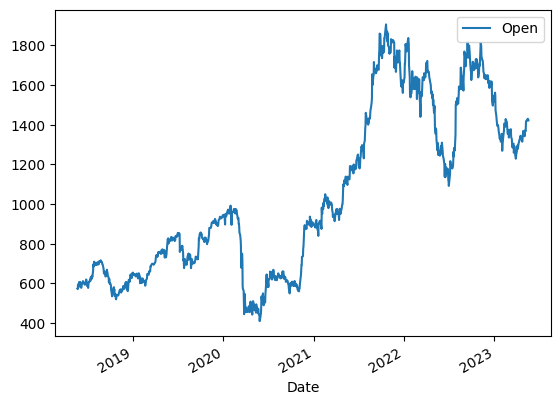

In [15]:
opn.plot()

In [16]:
import matplotlib.pyplot as plt

In [17]:
ds = opn.values

In [18]:
ds


array([[ 573.5       ],
       [ 571.5       ],
       [ 594.90002441],
       ...,
       [1430.40002441],
       [1422.34997559],
       [1422.09997559]])

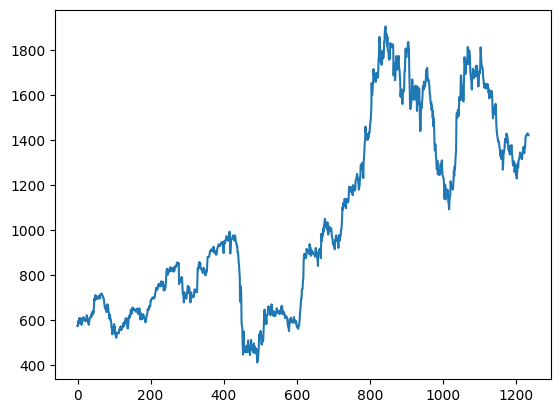

In [19]:
plt.plot(ds)

In [20]:
import numpy as np

In [21]:
from sklearn.preprocessing import MinMaxScaler

In [22]:
#Using MinMaxScaler for normalizing data between 0 & 1
normalizer = MinMaxScaler(feature_range=(0,1))
ds_scaled = normalizer.fit_transform(np.array(ds).reshape(-1,1))

In [23]:
len(ds_scaled), len(ds)

(1235, 1235)

In [24]:
#Defining test and train data sizes
train_size = int(len(ds_scaled)*0.70)
test_size = len(ds_scaled) - train_size

In [25]:
train_size,test_size

(864, 371)

In [26]:
#Splitting data between train and test
ds_train, ds_test = ds_scaled[0:train_size,:], ds_scaled[train_size:len(ds_scaled),:1]

In [27]:
len(ds_train),len(ds_test)

(864, 371)

In [28]:
#creating dataset in time series for LSTM model 
#X[100,120,140,160,180] : Y[200]
def create_ds(dataset,step):
    Xtrain, Ytrain = [], []
    for i in range(len(dataset)-step-1):
        a = dataset[i:(i+step), 0]
        Xtrain.append(a)
        Ytrain.append(dataset[i + step, 0])
    return np.array(Xtrain), np.array(Ytrain)

In [29]:
#creating dataset in time series for LSTM model 
#X[100,120,140,160,180] : Y[200]
def create_ds(dataset,step):
    Xtrain, Ytrain = [], []
    for i in range(len(dataset)-step-1):
        a = dataset[i:(i+step), 0]
        Xtrain.append(a)
        Ytrain.append(dataset[i + step, 0])
    return np.array(Xtrain), np.array(Ytrain)

In [30]:
#Taking 100 days price as one record for training
time_stamp = 100
X_train, y_train = create_ds(ds_train,time_stamp)
X_test, y_test = create_ds(ds_test,time_stamp)

In [31]:
X_train.shape,y_train.shape

((763, 100), (763,))

In [32]:
X_test.shape, y_test.shape

((270, 100), (270,))

In [33]:
#Reshaping data to fit into LSTM model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [34]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [35]:
#Creating LSTM model using keras
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50,return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1,activation='linear'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [29]:
#Training model with adam optimizer and mean squared error loss function
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64)

Epoch 1/100
12/12 [==============================] - 10s 298ms/step - loss: 0.0267 - val_loss: 0.0359
Epoch 2/100
12/12 [==============================] - 2s 205ms/step - loss: 0.0076 - val_loss: 0.0113
Epoch 3/100
12/12 [==============================] - 2s 196ms/step - loss: 0.0030 - val_loss: 0.0280
Epoch 4/100
12/12 [==============================] - 3s 210ms/step - loss: 0.0024 - val_loss: 0.0093
Epoch 5/100
12/12 [==============================] - 2s 201ms/step - loss: 0.0020 - val_loss: 0.0054
Epoch 6/100
12/12 [==============================] - 2s 199ms/step - loss: 0.0019 - val_loss: 0.0058
Epoch 7/100
12/12 [==============================] - 2s 197ms/step - loss: 0.0018 - val_loss: 0.0059
Epoch 8/100
12/12 [==============================] - 2s 187ms/step - loss: 0.0017 - val_loss: 0.0057
Epoch 9/100
12/12 [==============================] - 2s 185ms/step - loss: 0.0017 - val_loss: 0.0042
Epoch 10/100
12/12 [==============================] - 3s 237ms/step - loss: 0.0016 - val_l

In [30]:
model.save('my_stock_prediction_model')

INFO:tensorflow:Assets written to: my_stock_prediction_model\assets


INFO:tensorflow:Assets written to: my_stock_prediction_model\assets


In [36]:

loaded_model=tf.keras.models.load_model('my_stock_prediction_model')

In [45]:
#Predicitng on train and test data
train_predict = loaded_model.predict(X_train)
test_predict = loaded_model.predict(X_test)

9/9 [==============================] - 0s 48ms/step


In [46]:
train_predict = normalizer.inverse_transform(train_predict)
test_predict = normalizer.inverse_transform(test_predict)

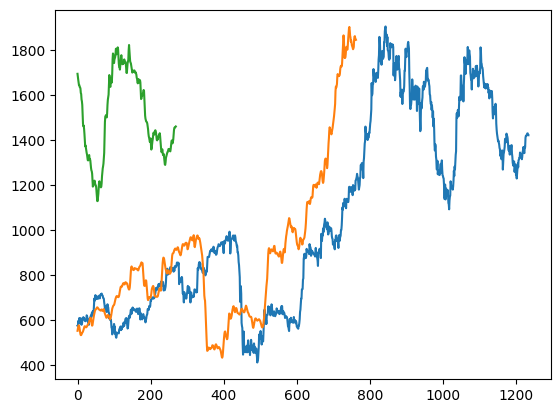

In [47]:
#Comparing using visuals
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(train_predict)
plt.plot(test_predict)

In [48]:
test = np.vstack((train_predict,test_predict))

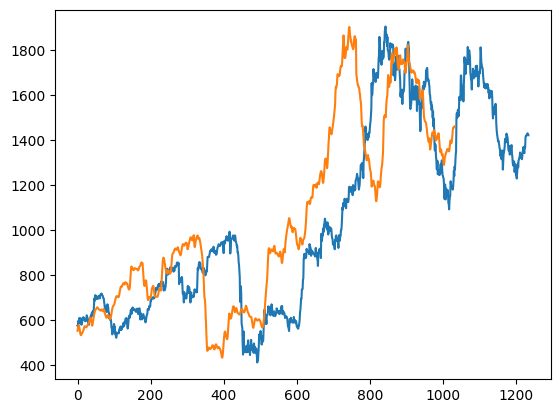

In [49]:
#Combining the predited data to create uniform data visualization
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(test)

In [50]:
len(ds_test)

371

In [51]:
#Getting the last 100 days records
fut_inp = ds_test[270:]

In [52]:
fut_inp = fut_inp.reshape(1,-1)

In [53]:
tmp_inp = list(fut_inp)

In [54]:
fut_inp.shape

(1, 101)

In [55]:
#Creating list of the last 100 data
tmp_inp = tmp_inp[0].tolist()

In [56]:
#Predicting next 10 days price suing the current data
#It will predict in sliding window manner (algorithm) with stride 1
lst_output=[]
n_steps=100
i=0
while(i<10):
    
    if(len(tmp_inp)>100):
        fut_inp = np.array(tmp_inp[1:])
        fut_inp=fut_inp.reshape(1,-1)
        fut_inp = fut_inp.reshape((1, n_steps, 1))
        yhat = loaded_model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        fut_inp = fut_inp.reshape((1, n_steps,1))
        yhat = loaded_model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[[0.7008336186408997], [0.7107802033424377], [0.7251166105270386], [0.739854097366333], [0.7538089156150818], [0.76665198802948], [0.7781692147254944], [0.788239061832428], [0.7969096302986145], [0.8044008016586304]]
